In [1]:
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
from rlxutils import subplots
import rasterio as rio
import netCDF4 as netcfd

## discover what datasets have been downloaded

In [50]:
datasets_dir = "data/conus_partitions_aschips_293d95e3ee589/"
datasets = os.listdir(datasets_dir)
datasets = [i for i in datasets if i!='firecci51']
datasets

['biomass-2020',
 's1grd-2020',
 'esaworldcover-2020',
 'strmdem',
 's2rgbm-2020',
 'ghsbuilts-2020',
 'gunw_2020-01-01_2020-03-31',
 'modis44b006veg',
 'gssic']

## get a list of chip ids existing in all datasets

In [5]:
chipids = None
for dataset in datasets:
    z = [i.split(".")[0] for i in os.listdir(f"{datasets_dir}/{dataset}")]
    if chipids is None:
        chipids = z
    else:
        chipids = np.r_[list(set(chipids).intersection(z))]
chipids

array(['115145c182573', '2c1a7f33fb7ff', '1122d72bf5929', '1f864ff2de2ff',
       '2f666401552e1', '07d00d673c2bd', '01be220189f77', '2fd48447443e1',
       '072e3a06bc49e', '2cfcab146184e', '015084acbf7dc', '0b0999359260d',
       '303ca2a9aeb4f', '29301012c742e', '1cad5365f7d3b', '0f6826d7f42c7',
       '2b1f1cb4cc852', '22be8f11396fe', '036baa35ffe0c', '2dbe6ebf00c92'],
      dtype='<U13')

## inspect the same chip in each dataset

In [6]:
chipid = chipids[np.random.randint(len(chipids))]
chipid

'0f6826d7f42c7'

### sentinel 2 rgb monthly 2020

has an rgb channel set for each month, in total 36 bands. 

observe how we use `rasterio` and the `.description` field contains the description of each channel

In [7]:
fname = f"{datasets_dir}/s2rgbm-2020/{chipid}.tif"
d = rio.open(fname)
descrips = np.r_[list(d.descriptions)]
x = d.read()
d.close()
descrips

array(['01_red', '01_green', '01_blue', '02_red', '02_green', '02_blue',
       '03_red', '03_green', '03_blue', '04_red', '04_green', '04_blue',
       '05_red', '05_green', '05_blue', '06_red', '06_green', '06_blue',
       '07_red', '07_green', '07_blue', '08_red', '08_green', '08_blue',
       '09_red', '09_green', '09_blue', '10_red', '10_green', '10_blue',
       '11_red', '11_green', '11_blue', '12_red', '12_green', '12_blue'],
      dtype='<U8')

In [8]:
# values are ints in the 0-255 range
x = np.transpose(x, (1,2,0))
x.shape, x.min(), x.max()

((448, 448, 36), 0, 255)

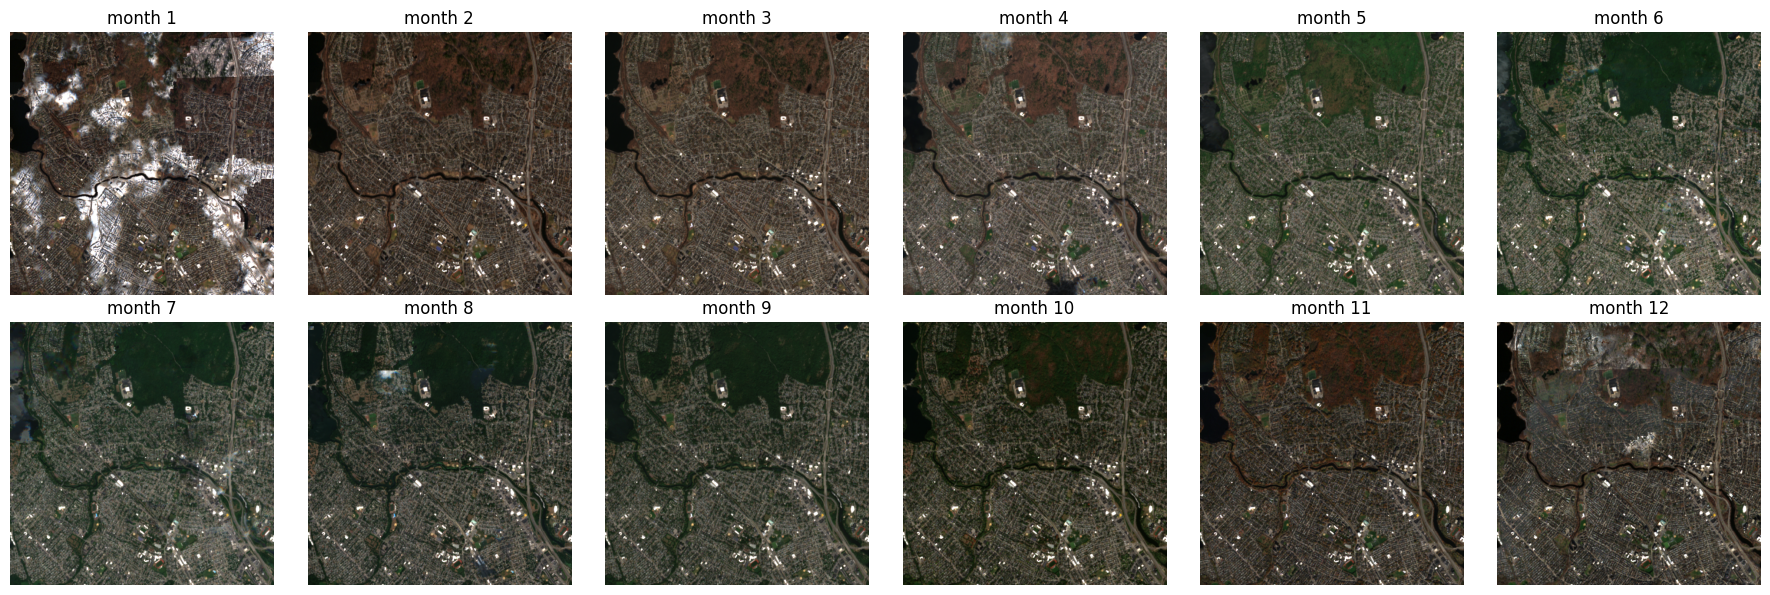

In [9]:
for ax,i in subplots(12, n_cols=6):
    plt.imshow(x[:,:,i*3:(i+1)*3])
    plt.title(f"month {i+1}")
    plt.axis('off')

### sentinel 1 grd seasonal 2020

for each polarity (vv or vh) and season the dataset averages separately all descending and ascending passes

note that 

- we must convert to `uint8`
- when plotting we clip to 1,99 percentiles of pixel values for better visualization

In [10]:
fname = f"{datasets_dir}/s1grd-2020/{chipid}.tif"
d = rio.open(fname)
x = d.read().astype(np.uint8)
descrips = np.r_[list(d.descriptions)]
d.close()
descrips

array(['winter_vvasc', 'winter_vvdes', 'winter_vhasc', 'winter_vhdes',
       'spring_vvasc', 'spring_vvdes', 'spring_vhasc', 'spring_vhdes',
       'summer_vvasc', 'summer_vvdes', 'summer_vhasc', 'summer_vhdes',
       'fall_vvasc', 'fall_vvdes', 'fall_vhasc', 'fall_vhdes'],
      dtype='<U12')

mode vvasc, extracting channels [ 0  4  8 12]
mode vvdes, extracting channels [ 1  5  9 13]
mode vhasc, extracting channels [ 2  6 10 14]
mode vhdes, extracting channels [ 3  7 11 15]


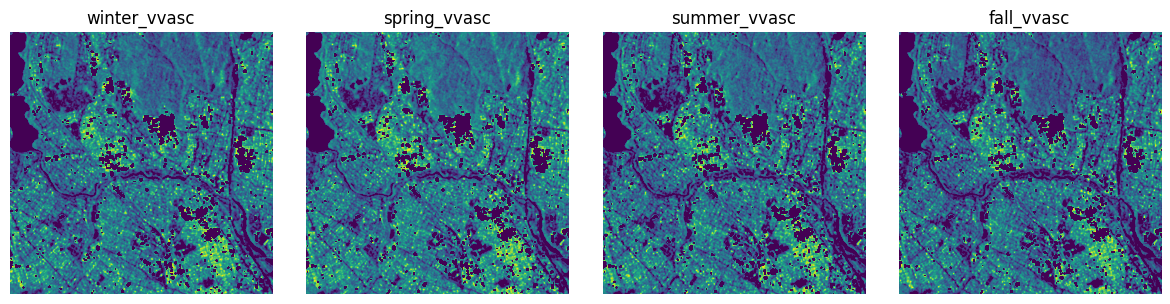

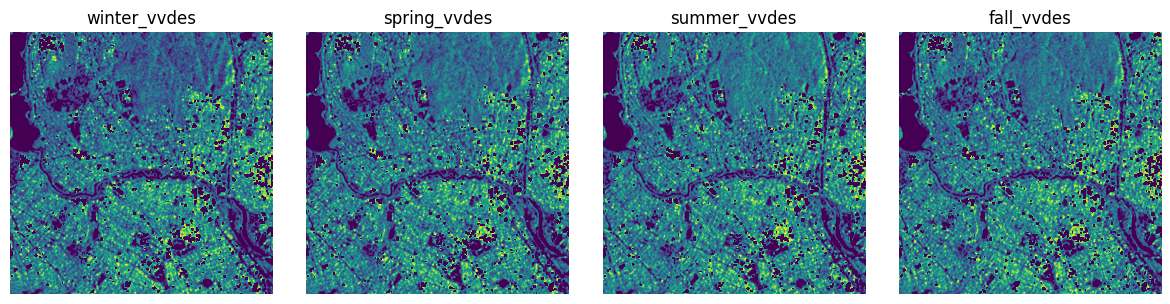

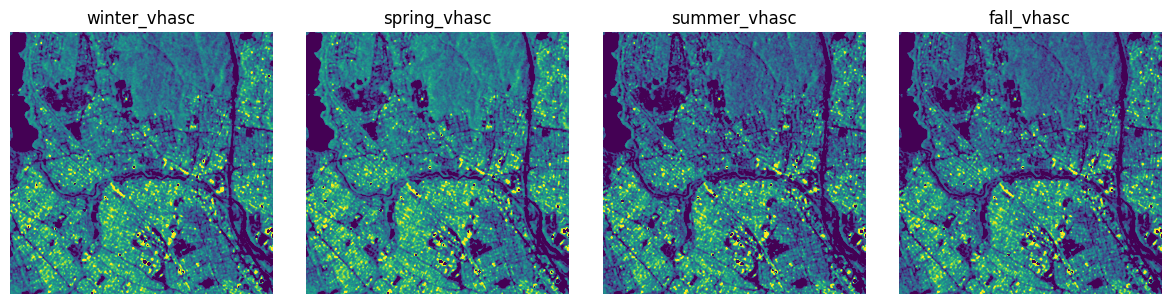

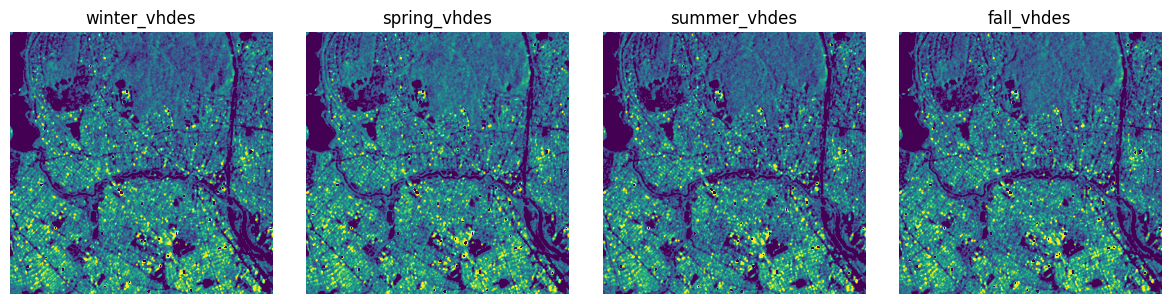

In [11]:
mode = 'vvasc'

for mode in ['vvasc', 'vvdes', 'vhasc', 'vhdes']:
    channels = np.argwhere([mode in i for i in descrips])[:,0]
    print (f"mode {mode}, extracting channels {channels}")
    a,b = np.percentile(x[channels], [10,99])
    for ax,i in subplots(channels):
        plt.imshow(x[i], vmin=a, vmax=b)
        plt.title(descrips[i])
        plt.axis('off')

### biomass-2020

in `netcfd` format, there is a single value for the `time` dimension on the `agb` variable

In [12]:
fname = f"{datasets_dir}/biomass-2020/{chipid}.nc"
d = xr.open_dataset(fname)
x = d.agb[0].values
d

<xarray.Dataset>
Dimensions:    (lon: 61, lat: 45, time: 1, nv: 2)
Coordinates:
  * lon        (lon) float64 -71.15 -71.15 -71.15 -71.15 ... -71.1 -71.1 -71.1
  * lat        (lat) float64 42.44 42.44 42.44 42.44 ... 42.4 42.4 42.4 42.4
  * time       (time) datetime64[ns] 2020-01-01
Dimensions without coordinates: nv
Data variables:
    agb        (time, lat, lon) float32 ...
    agb_se     (time, lat, lon) float32 ...
    crs        |S1 ...
    lon_bnds   (lon, nv) float64 ...
    lat_bnds   (lat, nv) float64 ...
    time_bnds  (time, nv) datetime64[ns] ...
Attributes: (12/43)
    title:                      ESA CCI above-ground biomass product level 4,...
    institution:                GAMMA Remote Sensing
    source:                     ALOS-2 PALSAR-2 FB and WB mosaics, Sentinel-1...
    history:                    AGB estimation with BIOMASAR-L, v202301, AGB ...
    references:                 http://cci.esa.int/biomass
    tracking_id:                cd5cb1d2-e582-41ab-a0fc-637f050baf9e
    ...                         ...
    geospatial_lat_units:       degrees_north
    geospatial_lon_resolution:  0.00088889
    geospatial_lat_resolution:  0.00088889
    date_created:               21-Mar-2023 06:16:52
    EPSG:                       4326
    proj4:                      +proj=longlat +datum=WGS84 +no_defs

In [13]:
d.close()

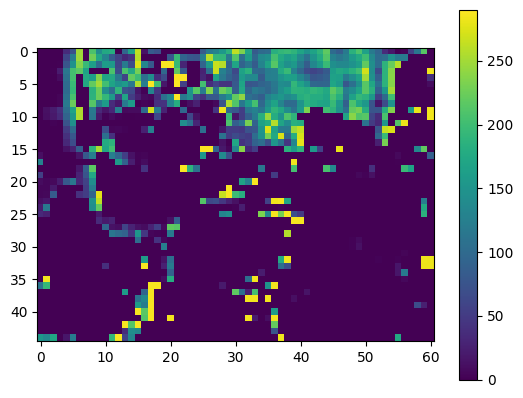

In [14]:
plt.imshow(x)
plt.colorbar()

### esaworldcover-2020

there is a single band with the landcover classes of 2020

In [15]:
fname = f"{datasets_dir}/esaworldcover-2020/{chipid}.tif"
d = rio.open(fname)
descrips = np.r_[list(d.descriptions)]
x = d.read()
d.close()
descrips, x.shape

(array(['Map'], dtype='<U3'), (1, 448, 448))

In [16]:
d.close()

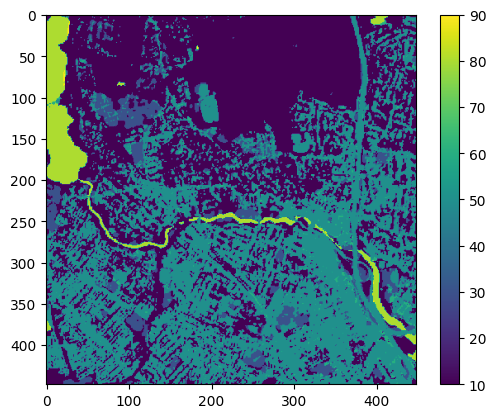

In [17]:
plt.imshow(x[0])
plt.colorbar()

### modis vegetation percentage 

the dataset contains several years

In [18]:
fname = f"{datasets_dir}/modis44b006veg/{chipid}.tif"
d = rio.open(fname)
descrips = np.r_[list(d.descriptions)]
x = d.read()
d.close()
descrips, x.shape

(array(['Percent_Tree_Cover_2016', 'Percent_Tree_Cover_2017',
        'Percent_Tree_Cover_2018', 'Percent_Tree_Cover_2019',
        'Percent_Tree_Cover_2020'], dtype='<U23'),
 (5, 448, 448))

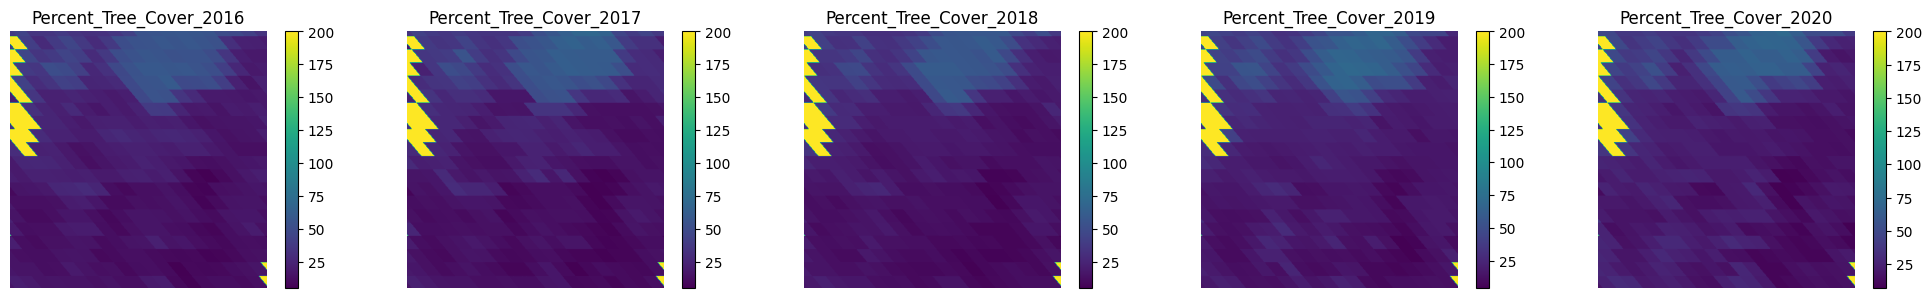

In [19]:
for ax,i in subplots(len(descrips), usizex=4):
    plt.imshow(x[i])
    plt.title(descrips[i])
    plt.axis('off')
    plt.colorbar()

## global human settlement layers built-up surface 2020

In [20]:
fname = f"{datasets_dir}/ghsbuilts-2020/{chipid}.tif"
d = rio.open(fname)
descrips = np.r_[list(d.descriptions)]
x = d.read()
d.close()
descrips, x.shape

(array(['band_data'], dtype='<U9'), (1, 28, 37))

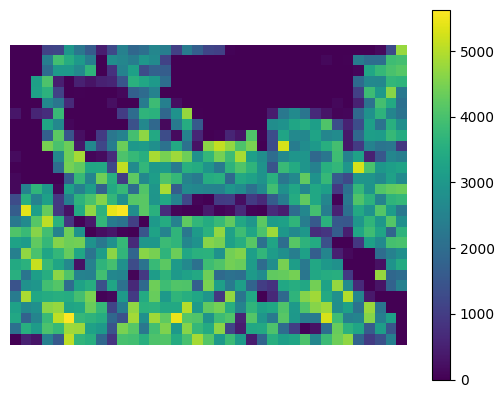

In [21]:
plt.imshow(x[0])
plt.axis('off')
plt.colorbar()

### srtm elevation model

we have the elevation and the slope

In [61]:
fname = f"{datasets_dir}/strmdem/{chipid}.tif"
d = rio.open(fname)
descrips = np.r_[list(d.descriptions)]
x = d.read()
d.close()
descrips, x.shape

(array(['elevation', 'slope'], dtype='<U9'), (2, 448, 448))

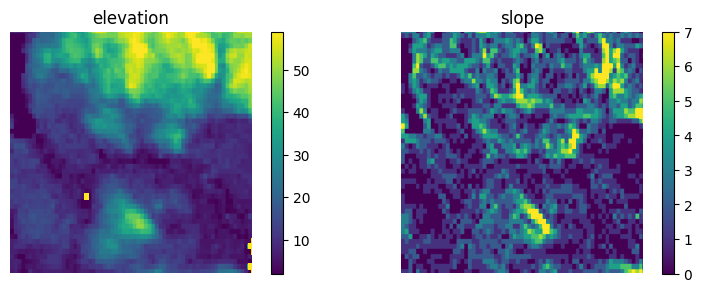

In [62]:
for ax,i in subplots(2, usizex=4):
    a,b = np.percentile(x[i], [1,99])
    plt.imshow(x[i], vmin=a, vmax=b)
    plt.title(descrips[i])
    plt.colorbar()
    plt.axis("off")

### Sentinel 1 interferometry and coherence gunw_2020-01-01_2020-03-31

this `netcfd` file uses groups to store different things. you can use the `netcfd` library to inspect the groups and then either continue using `netcfd` or use `xarray` to access the dats.

- the group `science/grids/data` contain the main raster data (coherence, interferogram)
- the group `science/grids/imagingGeometry` contain raster data of the acquisition geometry

In [25]:
fname = f"{datasets_dir}/gunw_2020-01-01_2020-03-31/{chipid}.nc"

d = netcfd.Dataset(fname)
d.groups

{'science': <class 'netCDF4._netCDF4.Group'>
 group /science:
     dimensions(sizes): 
     variables(dimensions): 
     groups: grids, radarMetaData, extraMetaData}

In [26]:
d['science'].groups

{'grids': <class 'netCDF4._netCDF4.Group'>
 group /science/grids:
     dimensions(sizes): 
     variables(dimensions): 
     groups: data, imagingGeometry,
 'radarMetaData': <class 'netCDF4._netCDF4.Group'>
 group /science/radarMetaData:
     dimensions(sizes): datepair(45)
     variables(dimensions): <class 'str'> datepair(datepair), <class 'str'> missionID(datepair), float32 wavelength(datepair), float32 centerFrequency(datepair), <class 'str'> productType(datepair), <class 'str'> ISCEversion(datepair), <class 'str'> unwrapMethod(datepair), <class 'str'> DEM(datepair), float32 ESDthreshold(datepair), <class 'str'> azimuthZeroDopplerStartTime(datepair), <class 'str'> azimuthZeroDopplerEndTime(datepair), float32 azimuthTimeInterval(datepair), float32 slantRangeSpacing(datepair), float32 slantRangeEnd(datepair), float32 slantRangeStart(datepair), int32 crs()
     groups: ,
 'extraMetaData': <class 'netCDF4._netCDF4.Group'>
 group /science/extraMetaData:
     description: calculated meta

In [27]:
dg = d['science']['grids']
dg

<class 'netCDF4._netCDF4.Group'>
group /science/grids:
    dimensions(sizes): 
    variables(dimensions): 
    groups: data, imagingGeometry

In [28]:
dg['data']

<class 'netCDF4._netCDF4.Group'>
group /science/grids/data:
    dimensions(sizes): datepair(45), longitude(66), latitude(48)
    variables(dimensions): <class 'str'> datepair(datepair), int32 crs(), float64 longitude(longitude), float64 latitude(latitude), float32 unwrappedPhase(datepair, latitude, longitude), float32 coherence(datepair, latitude, longitude), float32 connectedComponents(datepair, latitude, longitude), float32 amplitude(datepair, latitude, longitude)
    groups: 

In [29]:
# the datepairs of this object
datepairs = dg['data']['datepair'][:]
datepairs

array(['20200328_20200221', '20200328_20200304', '20200328_20200316',
       '20200323_20200216', '20200323_20200228', '20200323_20200311',
       '20200316_20200209', '20200316_20200221', '20200316_20200304',
       '20200311_20200204', '20200311_20200216', '20200311_20200228',
       '20200304_20200128', '20200304_20200209', '20200304_20200221',
       '20200228_20200123', '20200228_20200204', '20200228_20200216',
       '20200221_20200116', '20200221_20200128', '20200221_20200209',
       '20200216_20200111', '20200216_20200123', '20200216_20200204',
       '20200209_20200104', '20200209_20200116', '20200209_20200128',
       '20200204_20191230', '20200204_20200111', '20200204_20200123',
       '20200128_20191223', '20200128_20200104', '20200128_20200116',
       '20200123_20191218', '20200123_20191230', '20200123_20200111',
       '20200116_20191211', '20200116_20191223', '20200116_20200104',
       '20200111_20191206', '20200111_20191218', '20200111_20191230',
       '20200104_201

(45, 48, 66)

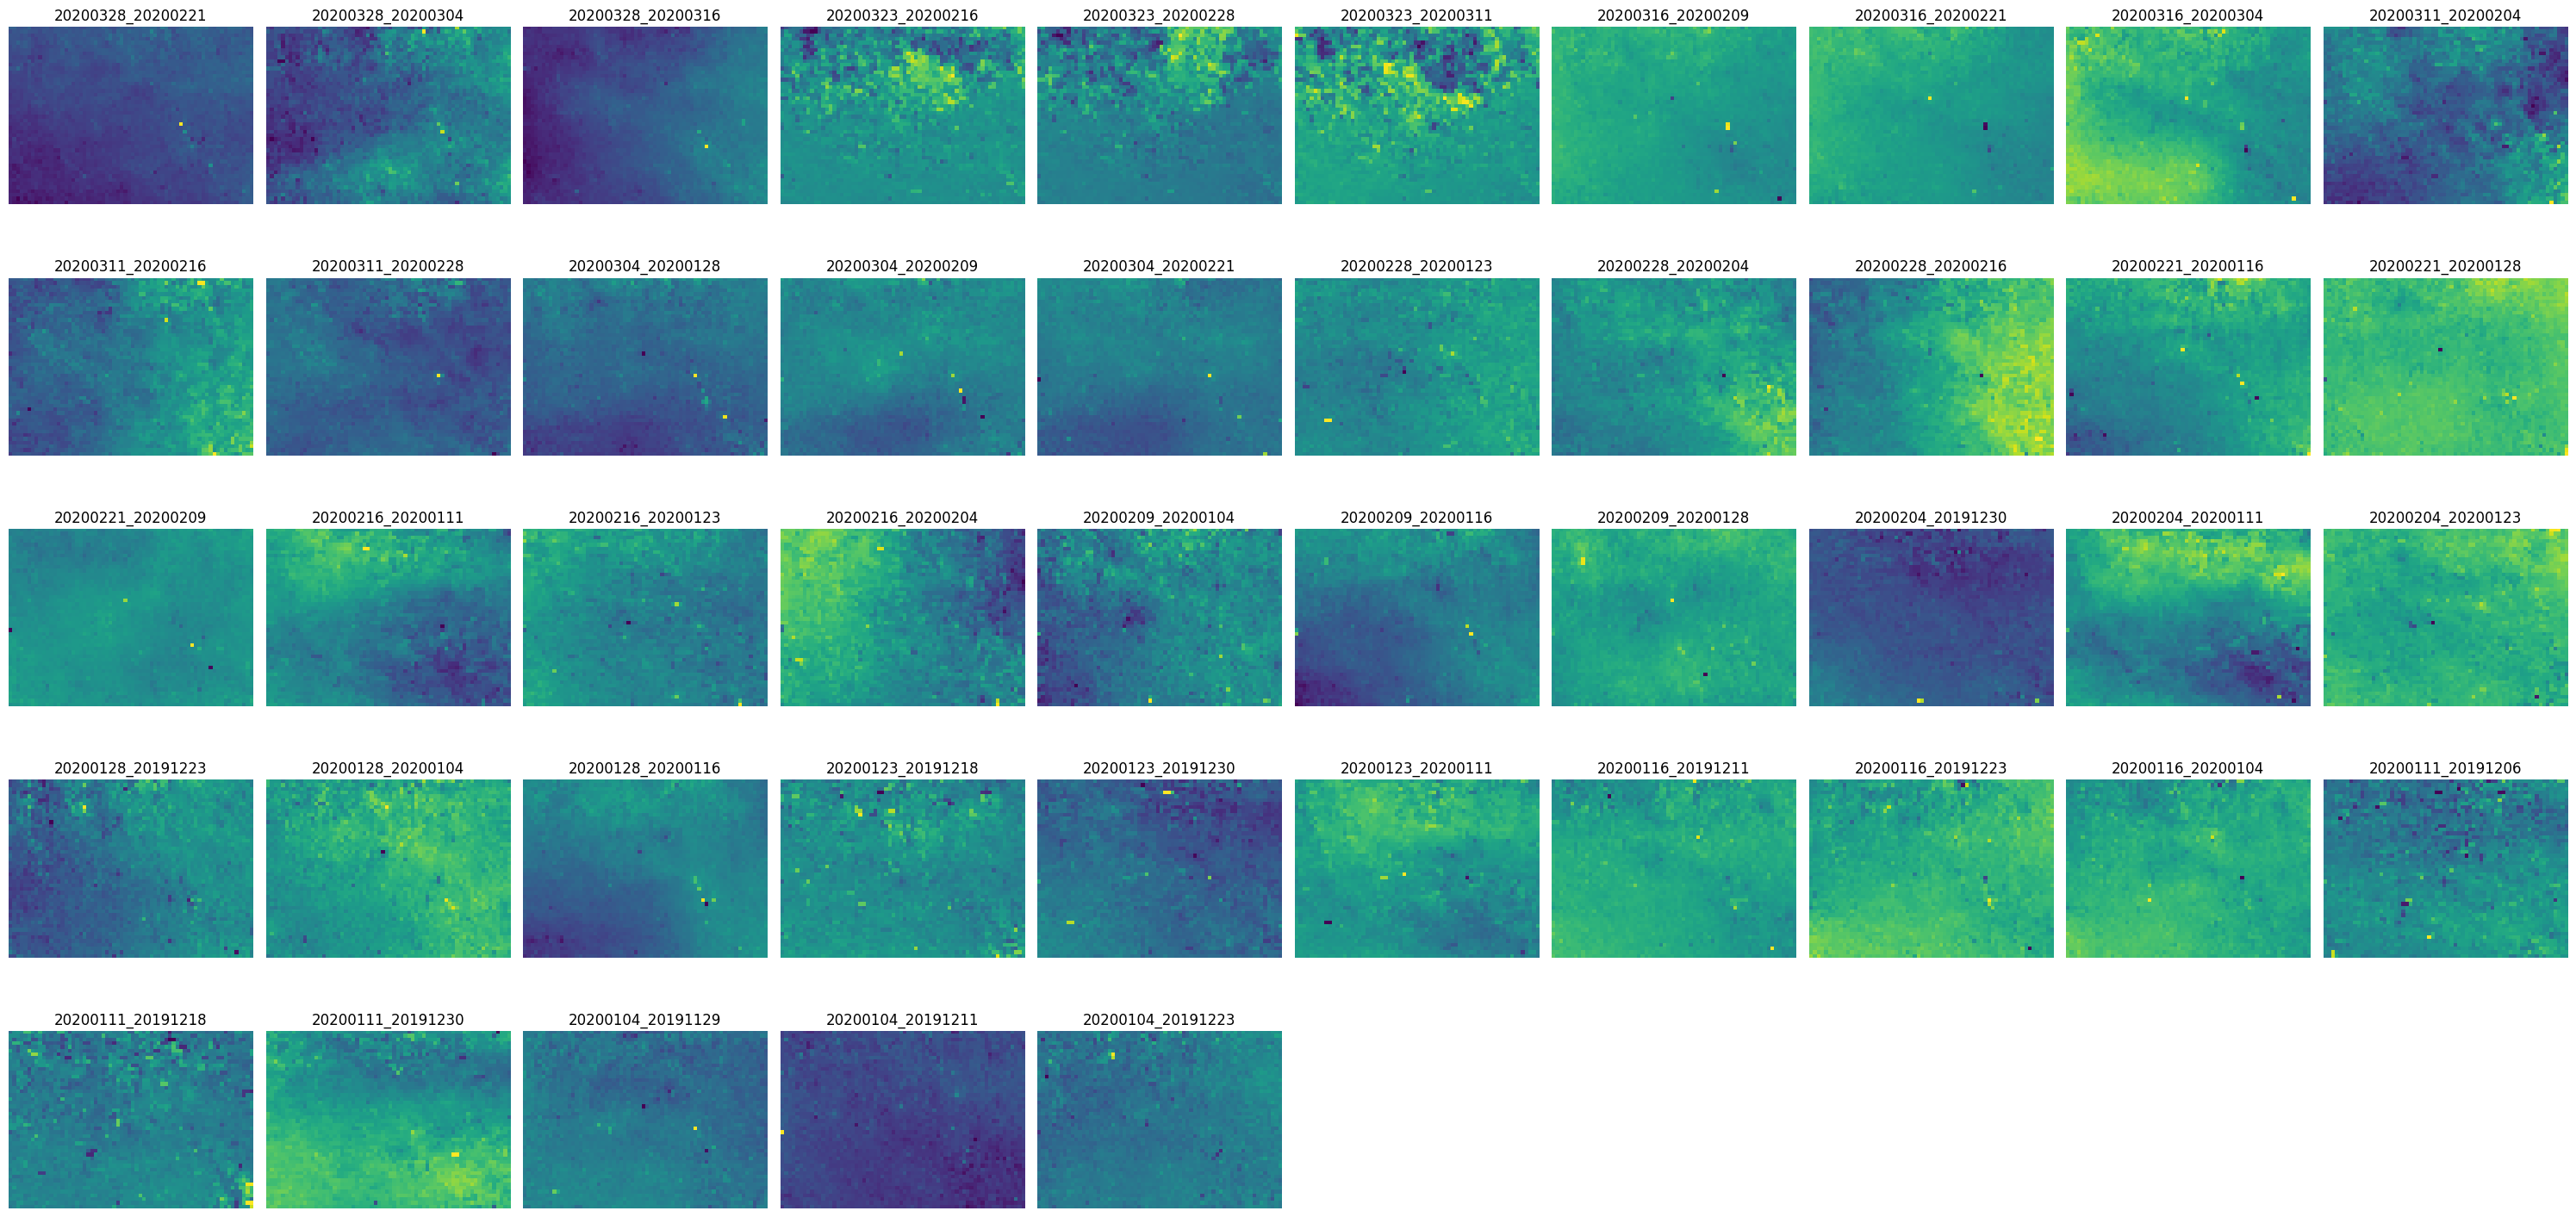

In [30]:
# the unwrapped interferograms for each date pair

x  = dg['data']['unwrappedPhase'][:]

for ax,i in subplots(len(datepairs), n_cols=10):
    plt.imshow(x[i])
    plt.title(datepairs[i])
    plt.axis('off')
    
x.shape

(45, 48, 66)

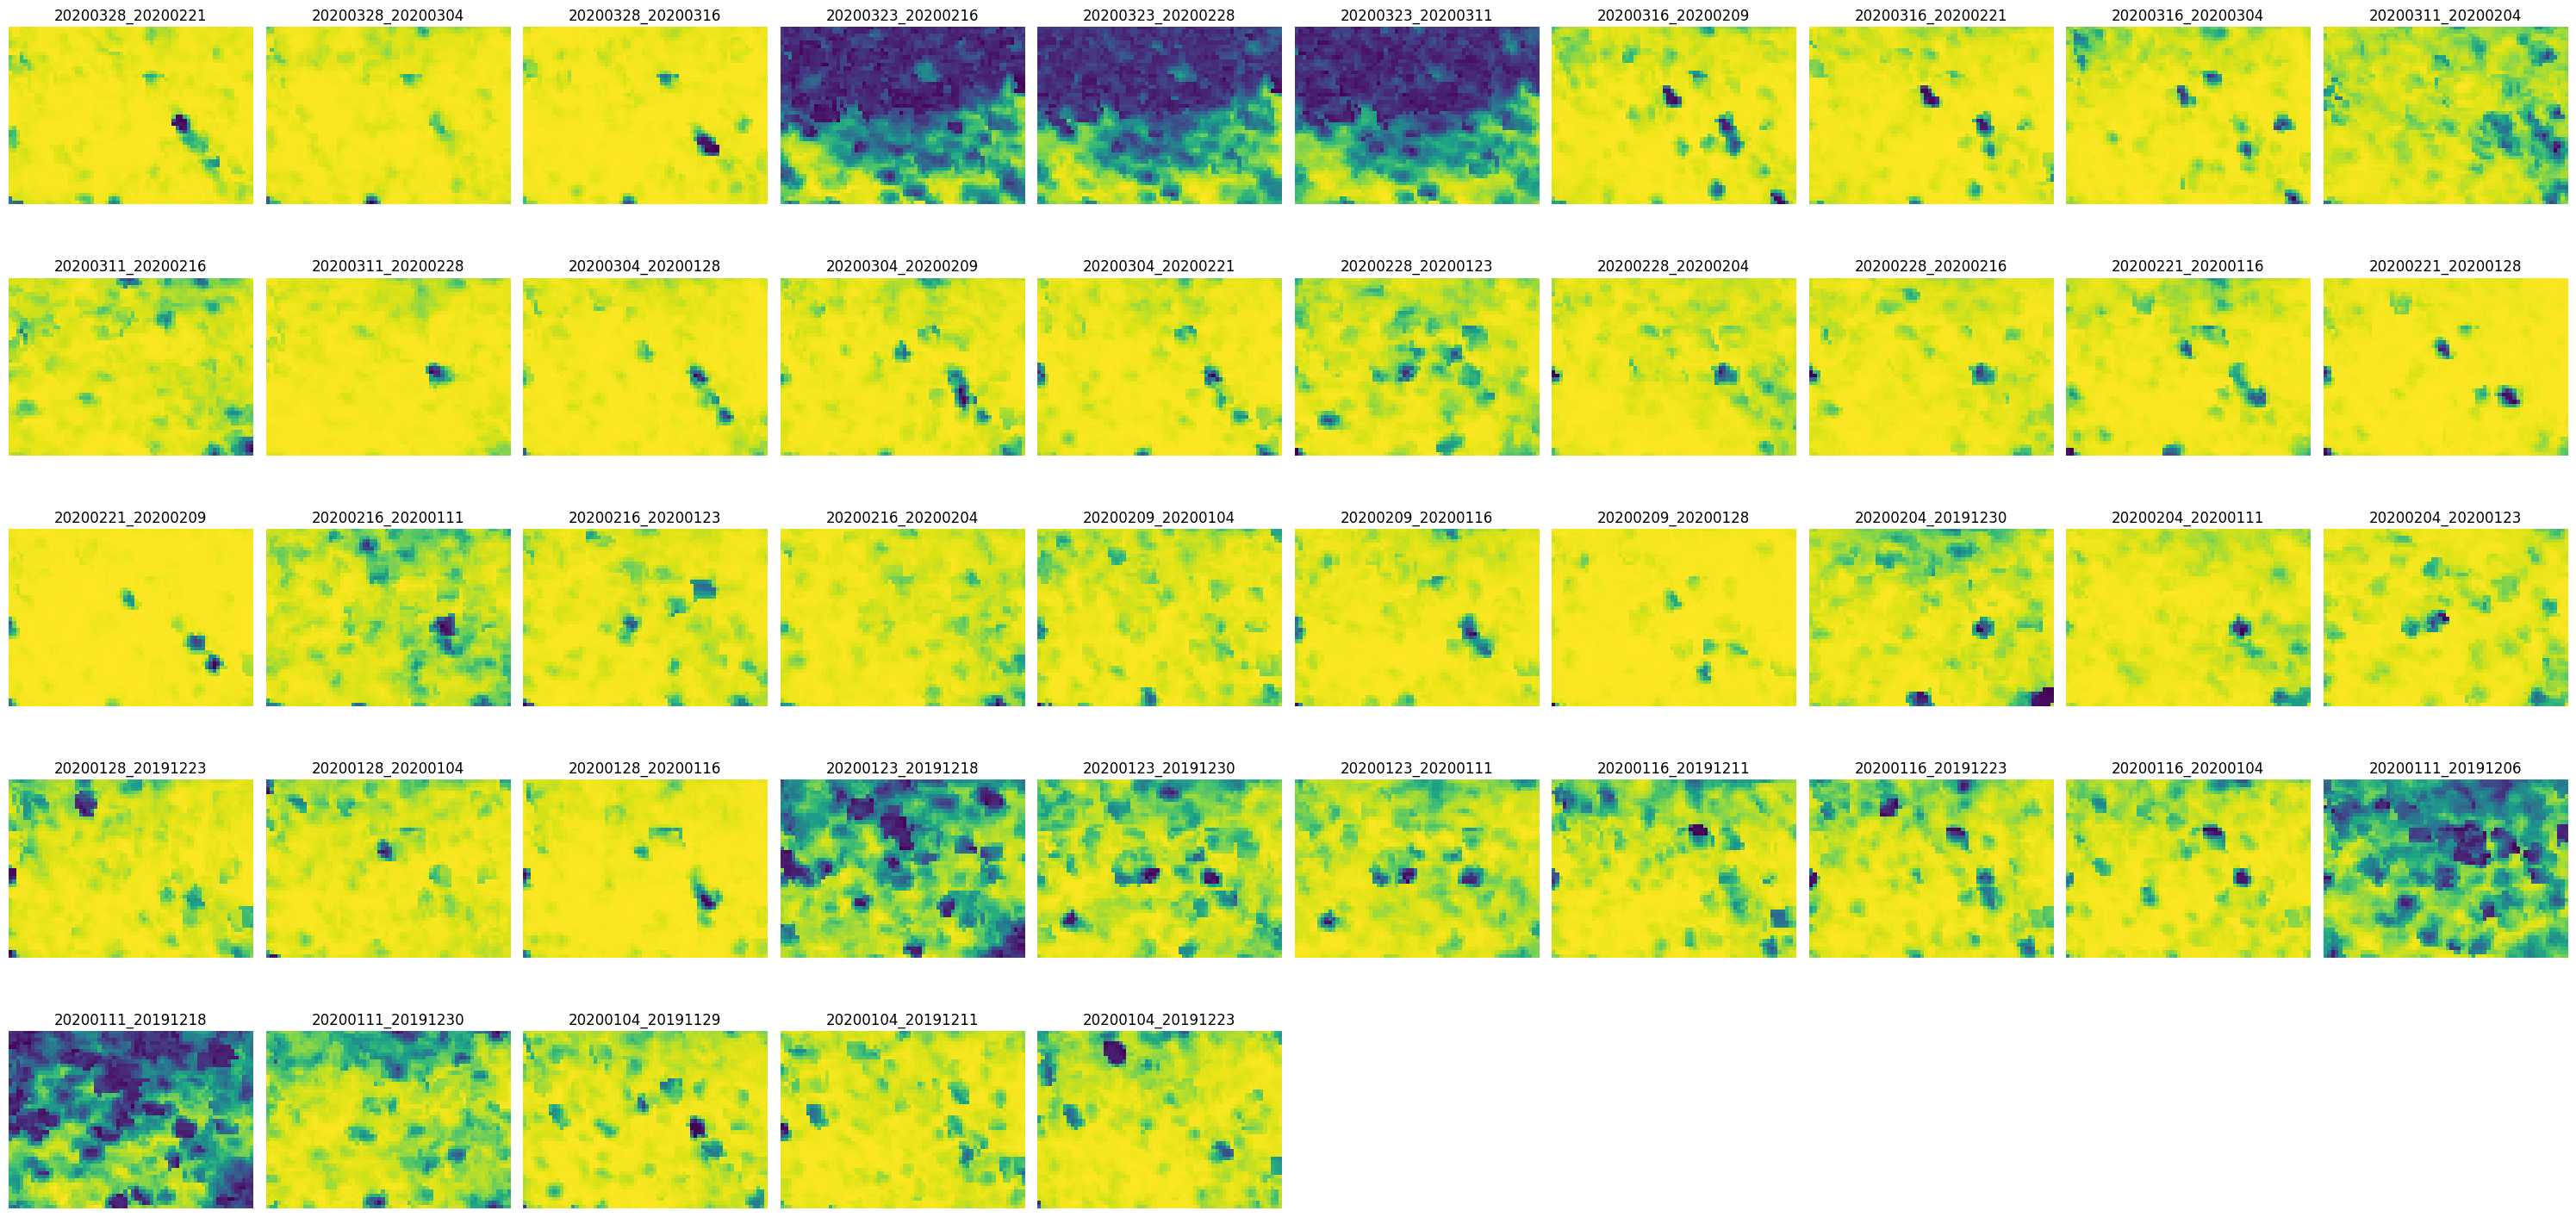

In [37]:
# the coherence of each date pair

x  = dg['data']['coherence'][:]
a,b = np.percentile(x, (5,95))
for ax,i in subplots(len(datepairs), n_cols=10):
    #plt.imshow(x[i], vmin=a, vmax=b)
    plt.imshow(x[i])
    plt.title(datepairs[i])
    plt.axis('off')
    
x.shape

In [38]:
# imageing geometry

dg['imagingGeometry']

<class 'netCDF4._netCDF4.Group'>
group /science/grids/imagingGeometry:
    dimensions(sizes): datepair(45), heightsMeta(4)
    variables(dimensions): <class 'str'> datepair(datepair), float32 crsMeta(datepair), float64 longitudeMeta(datepair), float64 latitudeMeta(), float64 heightsMeta(heightsMeta), float32 perpendicularBaseline(datepair, heightsMeta), float32 parallelBaseline(datepair, heightsMeta), float32 incidenceAngle(datepair, heightsMeta), float32 lookAngle(datepair, heightsMeta), float32 azimuthAngle(datepair, heightsMeta), int32 crs()
    groups: 

In [39]:
# for instance, the incidence angle for each date pair at 4 different heights, see GUNW ARIA doc
dg['imagingGeometry']['incidenceAngle'][:]

masked_array(
  data=[[43.141296, 43.20495 , 43.3327  , 43.590027],
        [43.141296, 43.20495 , 43.3327  , 43.590027],
        [43.141296, 43.20495 , 43.3327  , 43.590027],
        [33.016556, 33.07366 , 33.188404, 33.42001 ],
        [33.016556, 33.07366 , 33.188404, 33.42001 ],
        [33.016556, 33.07366 , 33.188404, 33.42001 ],
        [43.143394, 43.207047, 43.334797, 43.592125],
        [43.143394, 43.207047, 43.334797, 43.592125],
        [43.143394, 43.207047, 43.334797, 43.592125],
        [33.018734, 33.075844, 33.190586, 33.4222  ],
        [33.018734, 33.075844, 33.190586, 33.4222  ],
        [33.018734, 33.075844, 33.190586, 33.4222  ],
        [43.1399  , 43.20355 , 43.3313  , 43.588623],
        [43.1399  , 43.20355 , 43.3313  , 43.588623],
        [43.1399  , 43.20355 , 43.3313  , 43.588623],
        [33.01627 , 33.073376, 33.188114, 33.419716],
        [33.01627 , 33.073376, 33.188114, 33.419716],
        [33.01627 , 33.073376, 33.188114, 33.419716],
        [43.13

### global seasonal coherence (gssic)

this dataset contains interferometric averaged per season at different number of days difference in the interferometric pairs with which coherence is computed.

it also contains polarimetry, the parameters of an exponential model fitted to the obtained coherence in each season

In [42]:
fname = f"{datasets_dir}/gssic/{chipid}.nc"
d = xr.open_dataset(fname)
#x = d.agb[0].values
d

<xarray.Dataset>
Dimensions:      (season: 4, polarimetry: 2, y: 48, x: 65, deltadays: 4,
                  param: 3, feature: 2)
Coordinates:
  * deltadays    (deltadays) int64 12 24 36 48
  * polarimetry  (polarimetry) object 'vv' 'vh'
  * param        (param) object 'rho' 'tau' 'rmse'
  * feature      (feature) object 'inc' 'lsmap'
  * season       (season) object 'summer' 'fall' 'winter' 'spring'
  * x            (x) float64 -71.15 -71.15 -71.15 -71.15 ... -71.1 -71.1 -71.1
  * y            (y) float64 42.44 42.44 42.44 42.44 ... 42.4 42.4 42.4 42.4
Data variables:
    amplitude    (season, polarimetry, y, x) float32 ...
    coherence    (season, deltadays, y, x) float32 ...
    decaymodel   (season, param, y, x) float32 ...
    geometry     (feature, y, x) float32 ...
    spatial_ref  int64 ...

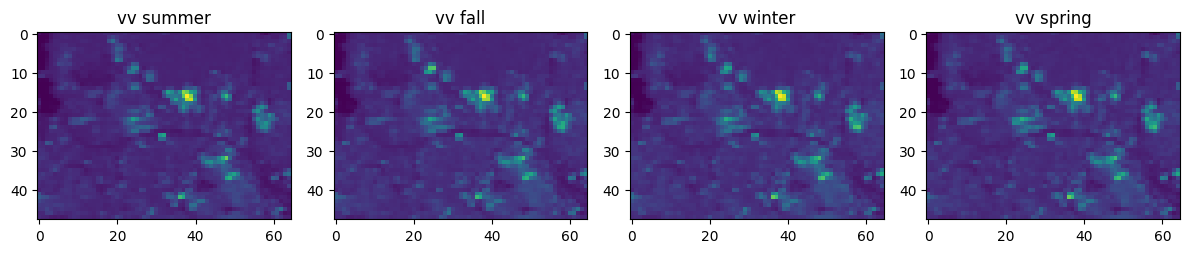

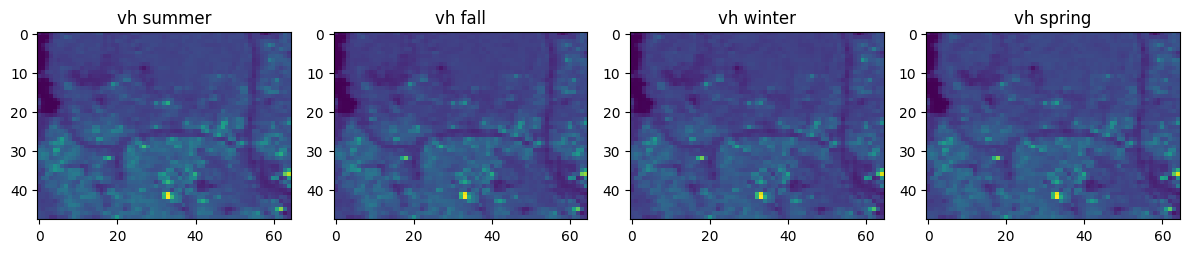

In [43]:
# amplitude

for polarimetry in d.polarimetry.values:
    x = d.amplitude.sel(polarimetry=polarimetry).values
    for ax,i in subplots(x.shape[0]):
        plt.imshow(x[i])
        plt.title(f"{polarimetry} {d.season.values[i]}")

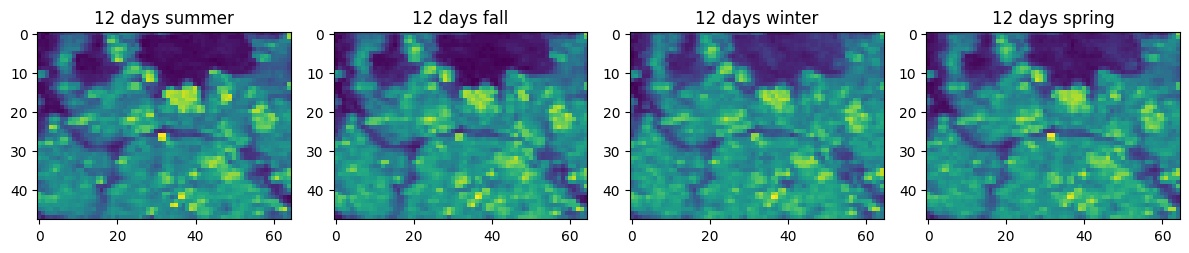

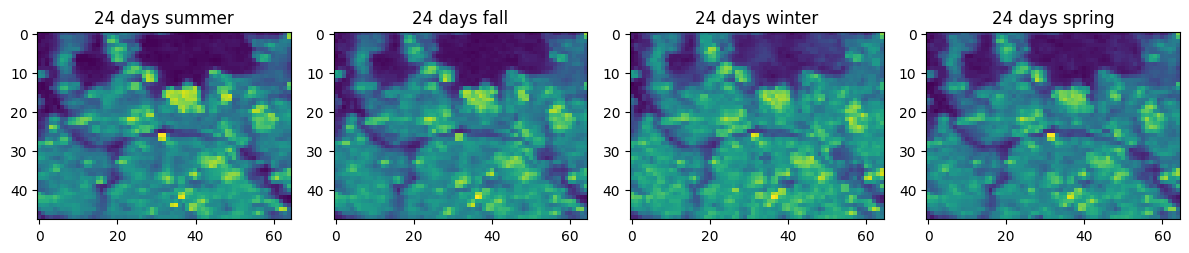

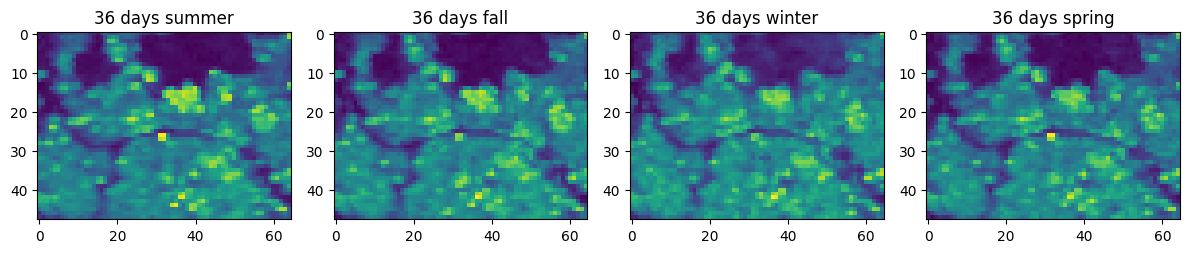

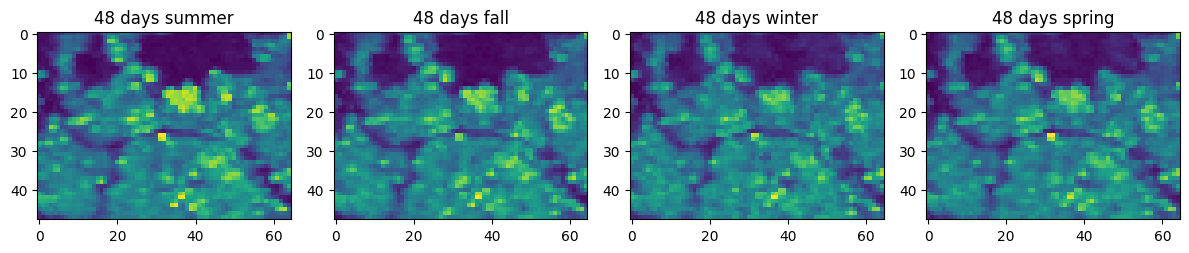

In [44]:
# coherence

for deltadays in d.deltadays.values:
    x = d.coherence.sel(deltadays=deltadays).values
    for ax,i in subplots(x.shape[0]):
        plt.imshow(x[i])
        plt.title(f"{deltadays} days {d.season.values[i]}")

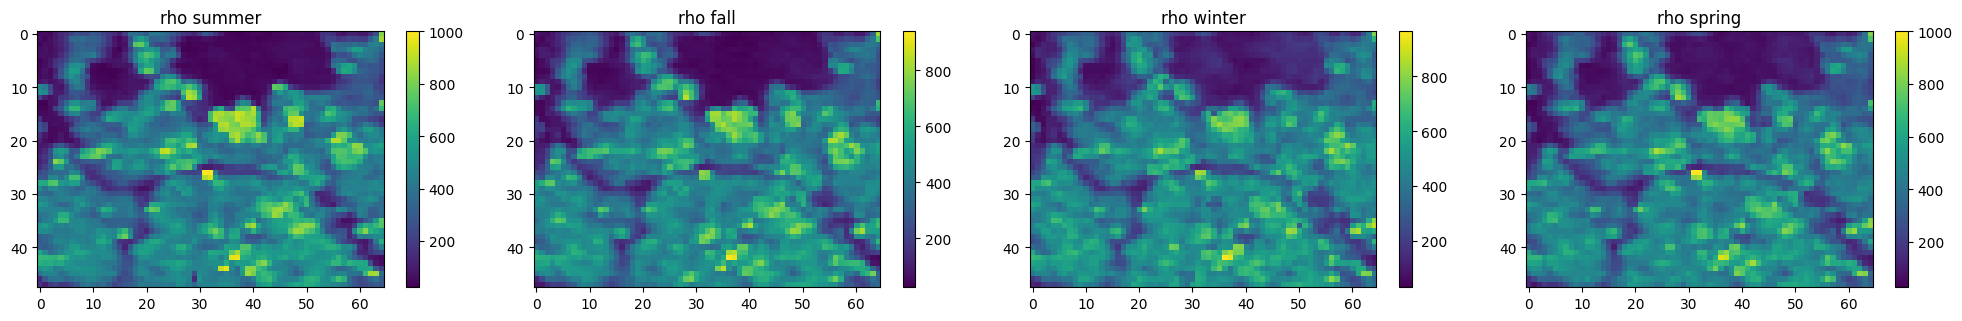

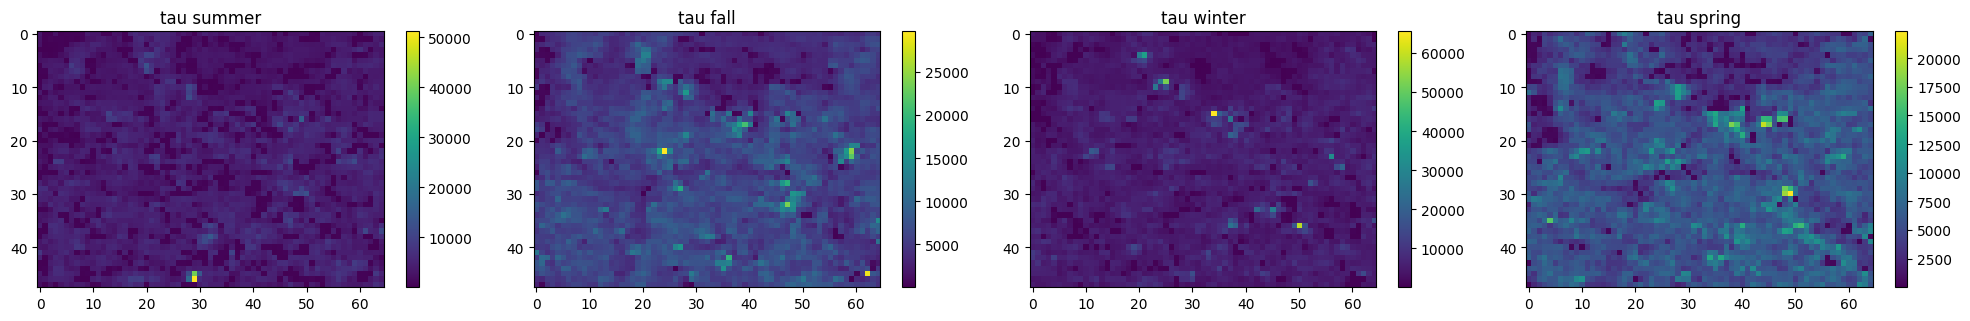

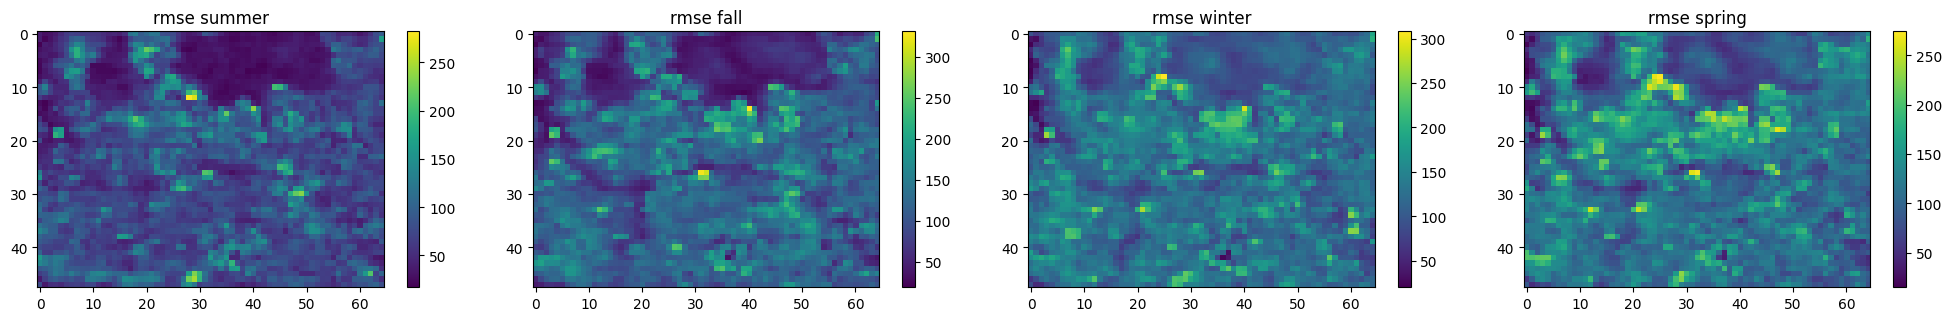

In [48]:
# decay model

for param in d.param.values:
    x = d.decaymodel.sel(param=param).values
    for ax,i in subplots(x.shape[0], usizex=5):
        plt.imshow(x[i])
        plt.title(f"{param} {d.season.values[i]}")
        plt.colorbar()

### firecci51 

the chip selected above might not have fires reported and will not be present in the firecci51 dataset, so we simply randomly select another chip with fires

observe that the chip contains data from 2016 to 2020 but it is likely that not all years have had fires

In [57]:
firechip = np.random.choice(os.listdir(f"{datasets_dir}/firecci51"))
firechip

'1a1446980befd.tif'

In [58]:
fname = f"{datasets_dir}/firecci51/{firechip}"
d = rio.open(fname)
descrips = np.r_[list(d.descriptions)]
x = d.read()
d.close()
descrips, x.shape

(array(['2016_BurnDate', '2016_ConfidenceLevel', '2016_LandCover',
        '2017_BurnDate', '2017_ConfidenceLevel', '2017_LandCover',
        '2018_BurnDate', '2018_ConfidenceLevel', '2018_LandCover',
        '2019_BurnDate', '2019_ConfidenceLevel', '2019_LandCover',
        '2020_BurnDate', '2020_ConfidenceLevel', '2020_LandCover'],
       dtype='<U20'),
 (15, 448, 448))

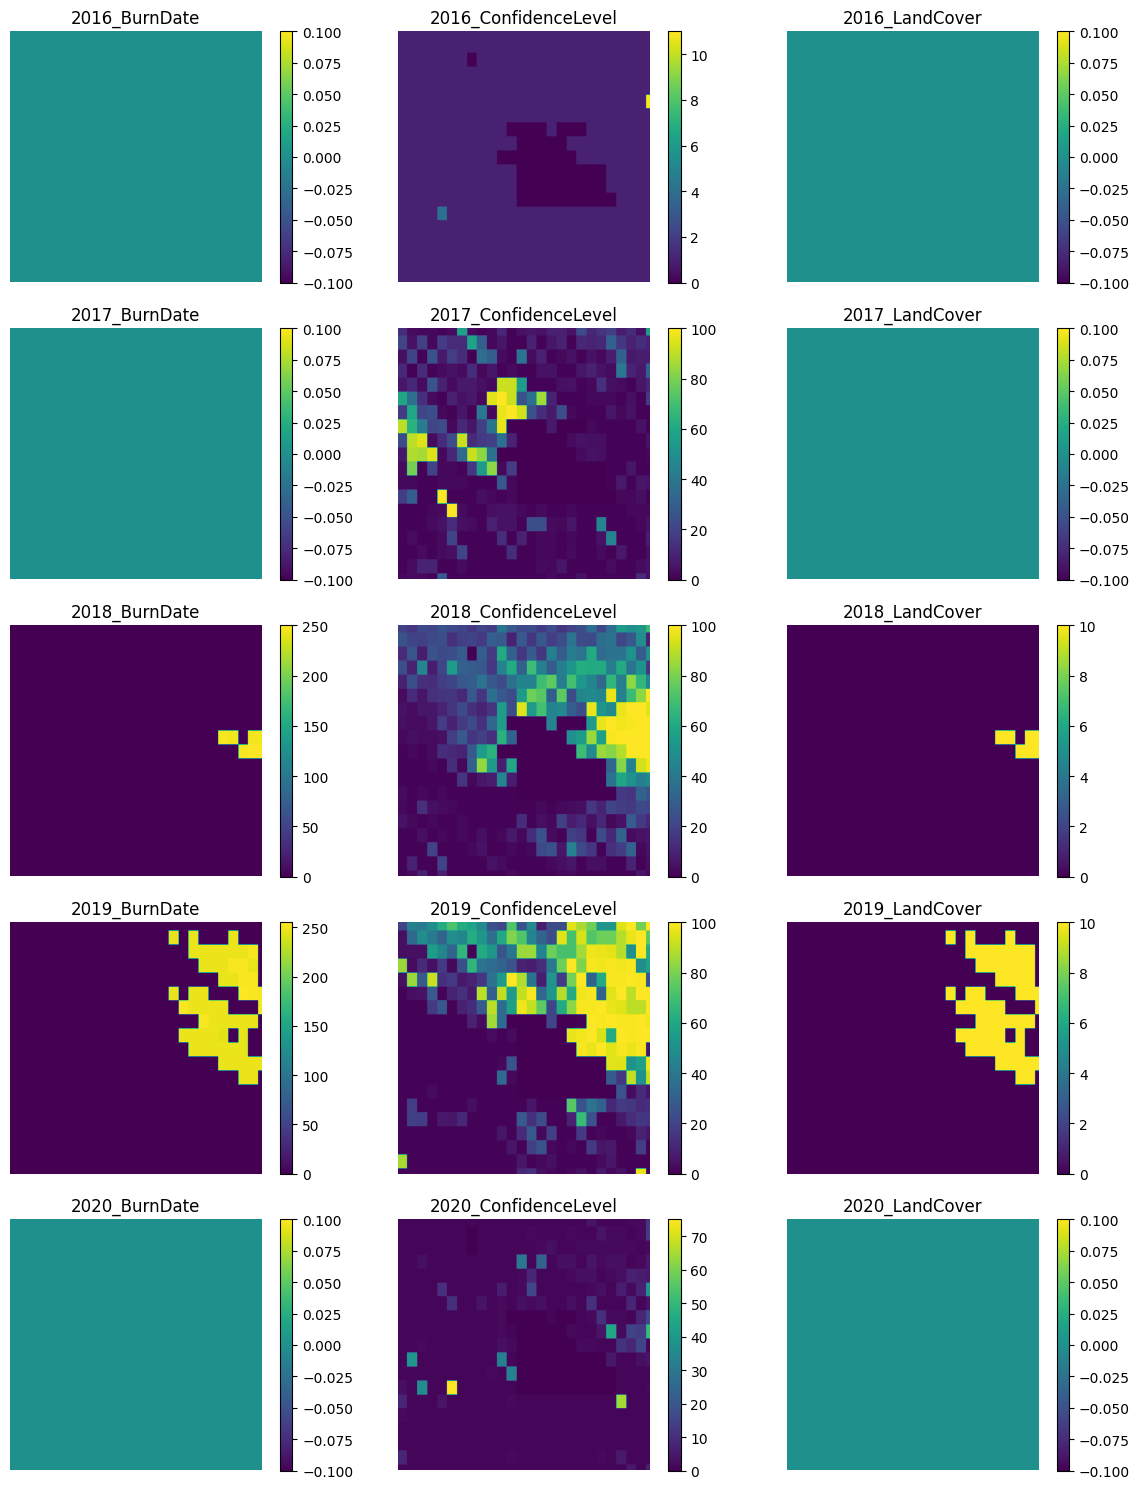

In [60]:
for ax,i in subplots(len(descrips), usizex=4, n_cols=3):
    plt.imshow(x[i])
    plt.title(descrips[i])
    plt.colorbar()
    plt.axis("off")